#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩
     - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam

In [5]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [6]:
# 주어진 데이터 셋을 불러오세요.(3개)
data01_train =  pd.read_csv(path+'data01_train.csv')
data01_test = pd.read_csv(path+'data01_test.csv')
feature = pd.read_csv(path+'features.csv')

In [7]:
#불필요한 칼럼을 삭제하세요.
data01_train = data01_train.drop('subject', axis=1)

#### 2) 기본 정보 조회

In [8]:
#전체 데이터의 행,열 개수 확인

print(data01_train.shape)
print(data01_test.shape)

(5881, 562)
(1471, 563)


In [9]:
#전체 데이터의 상위 5개 행 확인
data01_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [10]:
#전체 데이터의 수치형 변수 분포 확인
data01_train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [11]:
#전체 데이터의 모든 변수 확인
data01_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [12]:
# 데이터 분할을 합니다.
target = 'Activity'

x = data01_train.drop(target, axis=1)
y = data01_train[target]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=20)

### (2) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [13]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

### (3) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [14]:
# 정수 인코딩 변환(LabelEncoder)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [15]:
# 기존 레이블 저장
y_train

array([0, 2, 2, ..., 0, 3, 1])

### (4) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [16]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=20)

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - (옵션) 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

### (1) 모델1 : Hidden Layer 없이 모델 생성

In [17]:
# 모델 설계
n_feature = x_val.shape[1]
n_class = len(le.classes_)

model1 = Sequential([
    Dense(n_class, input_dim=n_feature, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
# 컴파일 및 학습
model1.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model1.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4636 - loss: 1.3499 - val_accuracy: 0.8172 - val_loss: 0.8165
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8178 - loss: 0.7545 - val_accuracy: 0.8470 - val_loss: 0.6208
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8628 - loss: 0.5762 - val_accuracy: 0.8959 - val_loss: 0.5064
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8793 - loss: 0.4902 - val_accuracy: 0.9033 - val_loss: 0.4353
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9009 - loss: 0.4159 - val_accuracy: 0.9139 - val_loss: 0.3889
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9074 - loss: 0.3820 - val_accuracy: 0.9129 - val_loss: 0.3506
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9146 - loss: 0.3354 - val_accuracy: 0.9203 - val_loss: 0.3225
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9158 - loss: 0.3201 - val_accuracy: 0.

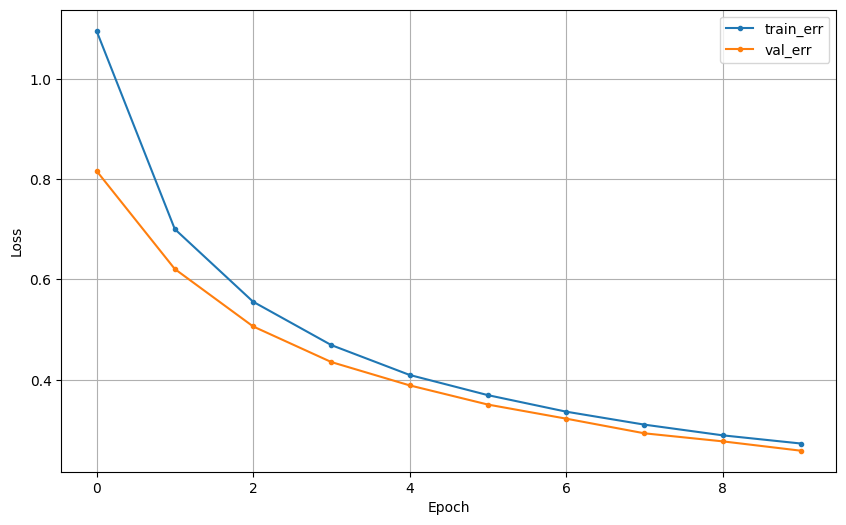

In [19]:
# 학습곡선
dl_history_plot(history.history)

In [20]:
# 예측 및 평가
loss, acc = model1.evaluate(x_val, y_val)
print('loss : ', loss)
print('acc : ', acc)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9459 - loss: 0.2505 
loss :  0.2586192190647125
acc :  0.935175359249115


In [21]:
#(옵션) 모델1번을 최소 5번 반복수행해서 얻은 성능의 평균값을 기록해보자!

### (2) 모델2 : 최소 5개 이상의 은닉층을 추가한 모델

In [22]:
# 모델 설계
n_feature = x_val.shape[1]
n_class = len(le.classes_)

model2 = Sequential([
    Dense(128, input_dim=n_feature, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(n_class, activation='softmax')
])

In [23]:
# 컴파일 및 학습
model2.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model2.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4251 - loss: 1.3966 - val_accuracy: 0.8342 - val_loss: 0.4468
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8640 - loss: 0.3781 - val_accuracy: 0.9033 - val_loss: 0.2638
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9048 - loss: 0.2440 - val_accuracy: 0.9214 - val_loss: 0.2165
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9269 - loss: 0.1877 - val_accuracy: 0.9628 - val_loss: 0.1364
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9494 - loss: 0.1422 - val_accuracy: 0.9671 - val_loss: 0.1092
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9490 - loss: 0.1350 - val_accuracy: 0.9713 - val_loss: 0.0864
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9630 - loss: 0.1010 - val_accuracy: 0.9702 - val_loss: 0.0879
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9665 - loss: 0.0887 - val_accuracy: 0.

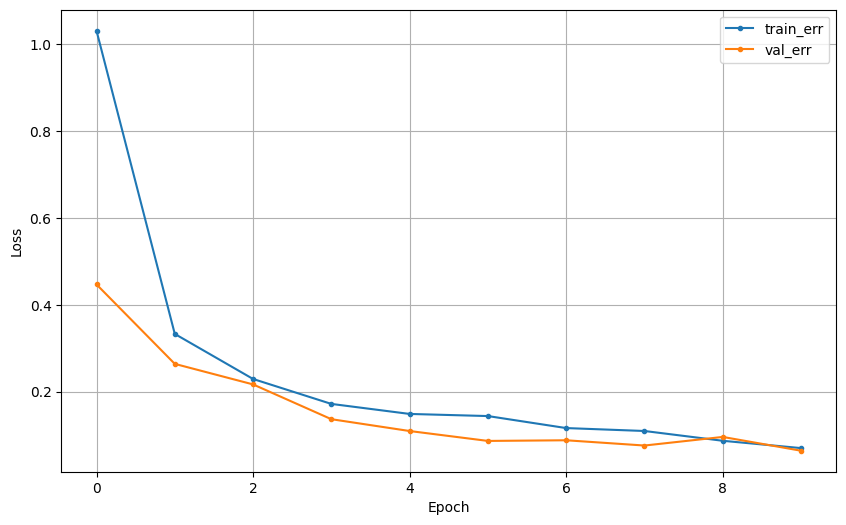

In [24]:
# 학습곡선
dl_history_plot(history.history)

In [25]:
# 예측 및 평가
loss, acc = model2.evaluate(x_val, y_val)
print('loss : ', loss)
print('acc : ', acc)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9821 - loss: 0.0556 
loss :  0.0638415738940239
acc :  0.9808714389801025


### (3) 모델3 : 학습률, epoch 등 조정

In [26]:
# 모델 설계
n_feature = x_val.shape[1]
n_class = len(le.classes_)

model3 = Sequential([
    Dense(128, input_dim=n_feature, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(n_class, activation='softmax')
])

In [27]:
# 컴파일 및 학습
model3.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model3.fit(x_train, y_train, epochs=15, validation_data=(x_val, y_val))

Epoch 1/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5174 - loss: 1.1390 - val_accuracy: 0.8066 - val_loss: 0.4528
Epoch 2/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8481 - loss: 0.3962 - val_accuracy: 0.9224 - val_loss: 0.2081
Epoch 3/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9146 - loss: 0.2182 - val_accuracy: 0.8438 - val_loss: 0.3600
Epoch 4/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9447 - loss: 0.1584 - val_accuracy: 0.9012 - val_loss: 0.2315
Epoch 5/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9415 - loss: 0.1466 - val_accuracy: 0.9702 - val_loss: 0.0960
Epoch 6/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9613 - loss: 0.1060 - val_accuracy: 0.9384 - val_loss: 0.1479
Epoch 7/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9591 - loss: 0.1127 - val_accuracy: 0.9469 - val_loss: 0.1396
Epoch 8/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9607 - loss: 0.0942 - val_accuracy: 0.

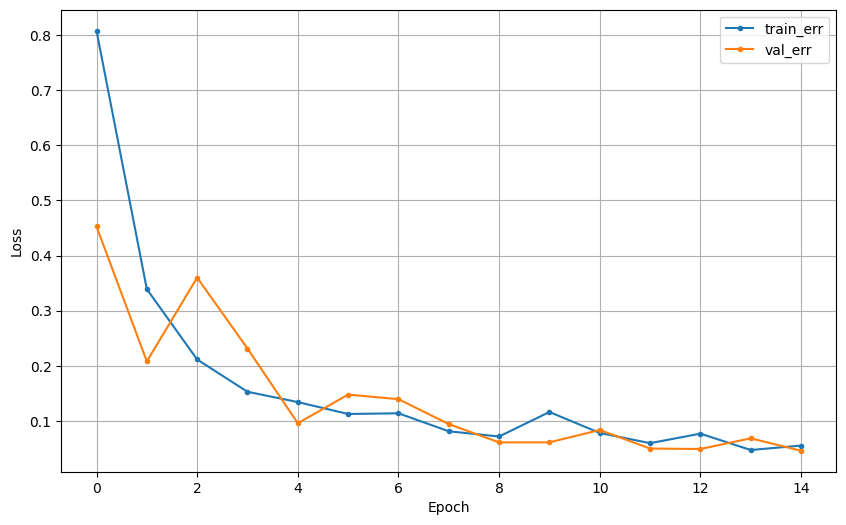

In [28]:
# 학습곡선
dl_history_plot(history.history)

In [29]:
# 예측 및 평가
loss, acc = model3.evaluate(x_val, y_val)
print('loss : ', loss)
print('acc : ', acc)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9908 - loss: 0.0333 
loss :  0.04612552374601364
acc :  0.9861848950386047


### (4) 모델4 :  학습률, epoch 등 조정

In [30]:
# 모델 설계
n_feature = x_val.shape[1]
n_class = len(le.classes_)

model4 = Sequential([
    Dense(128, input_dim=n_feature, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(n_class, activation='softmax')
])

In [31]:
# 컴파일 및 학습
model4.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model4.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3256 - loss: 1.7041 - val_accuracy: 0.3921 - val_loss: 1.4172
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3896 - loss: 1.3122 - val_accuracy: 0.5611 - val_loss: 1.0138
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6590 - loss: 0.9461 - val_accuracy: 0.7651 - val_loss: 0.7743
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7745 - loss: 0.7243 - val_accuracy: 0.8193 - val_loss: 0.6251
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8155 - loss: 0.5756 - val_accuracy: 0.8300 - val_loss: 0.5251
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8576 - loss: 0.4768 - val_accuracy: 0.8905 - val_loss: 0.4207
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8765 - loss: 0.4105 - val_accuracy: 0.8895 - val_loss: 0.3703
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8998 - loss: 0.3544 - val_accuracy: 0.

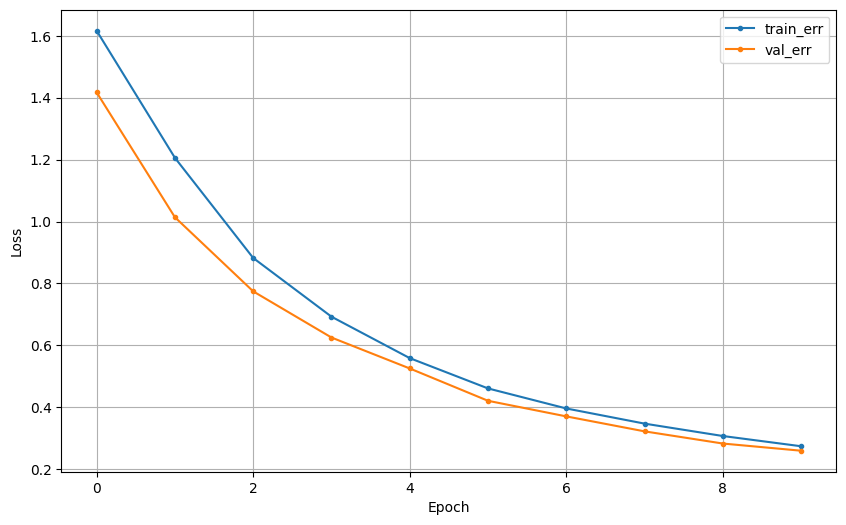

In [32]:
# 학습곡선
dl_history_plot(history.history)

In [33]:
# 예측 및 평가
loss, acc = model4.evaluate(x_val, y_val)
print('loss : ', loss)
print('acc : ', acc)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9402 - loss: 0.2490 
loss :  0.25938308238983154
acc :  0.9277364611625671


## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [34]:
#전체 데이터 불러오기(test)

# subject 삭제
data01_test = data01_test.drop('subject', axis=1)

# x, y 분할
x = data01_test.drop(target, axis=1)
y = data01_test[target]

# x : 스케일링 적용
x = scaler.transform(x)

# y : 정수인코딩 적용
y = le.transform(y)

In [35]:
# test 데이터에 대한 성능 측정

y_pred = model1.predict(x)
y_pred = np.argmax(y_pred, axis=1)
print("model1: ", accuracy_score(y, y_pred))

y_pred = model2.predict(x)
y_pred = np.argmax(y_pred, axis=1)
print("model2: ", accuracy_score(y, y_pred))

y_pred = model3.predict(x)
y_pred = np.argmax(y_pred, axis=1)
print("model3: ", accuracy_score(y, y_pred))

y_pred = model4.predict(x)
y_pred = np.argmax(y_pred, axis=1)
print("model4: ", accuracy_score(y, y_pred))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
model1:  0.9123045547246771
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
model2:  0.9571719918422842
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
model3:  0.9680489462950373
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
model4:  0.9068660774983005


#### 고생하셨습니다! 이제 단계적 모델링을 해봅시다.